In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('../input/pubg-finish-placement-prediction/train_V2.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

- **groupId** - Integer ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- **matchId** - Integer ID to identify match. There are no matches that are in both the training and testing set.
- **assists** - Number of enemy players this player damaged that were killed by teammates.
- **boosts** - Number of boost items used.
- **damageDealt** - Total damage dealt. Note: Self inflicted damage is subtracted.
- **DBNOs** - Number of enemy players knocked.
- **headshotKills** - Number of enemy players killed with headshots.
- **heals** - Number of healing items used.
- **killPlace** - Ranking in match of number of enemy players killed.
- **killPoints** - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.)
- **kills** - Number of enemy players killed.
- **killStreaks** - Max number of enemy players killed in a short amount of time.
- **longestKill** - Longest distance between player and player killed at time of death. This may be misleading, as downing a - player and driving away may lead to a large longestKill stat.
- **maxPlace** - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- **numGroups** - Number of groups we have data for in the match.
- **revives** - Number of times this player revived teammates.
- **rideDistance** - Total distance traveled in vehicles measured in meters.
- **roadKills** - Number of kills while in a vehicle.
- **swimDistance** - Total distance traveled by swimming measured in meters.
- **teamKills** - Number of times this player killed a teammate.
- **vehicleDestroys** - Number of vehicles destroyed.
- **walkDistance** - Total distance traveled on foot measured in meters.
- **weaponsAcquired** - Number of weapons picked up.
- **winPoints** - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.)
- **winPlacePerc** - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

** The Killers**

In [3]:
print("The average person kills {:.4f} players, 99% of people have {} kills or less, while the most kills ever recorded is {}.".format(train['kills'].mean(),train['kills'].quantile(0.99), train['kills'].max()))

The average person kills 0.9248 players, 99% of people have 7.0 kills or less, while the most kills ever recorded is 72.


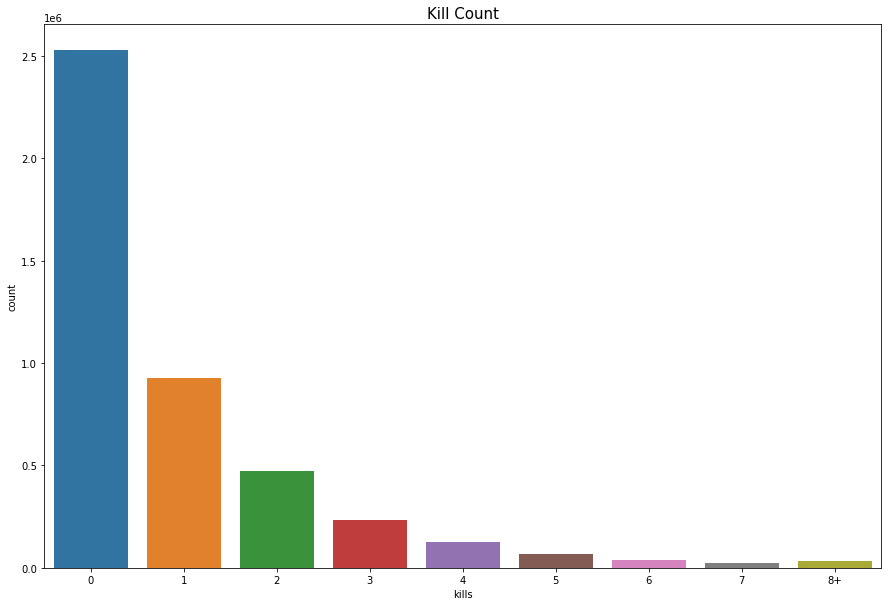

In [4]:
data = train.copy()
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,10))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count",fontsize=15)
plt.show()

Most people can't make a single kill. At least do they do damage?

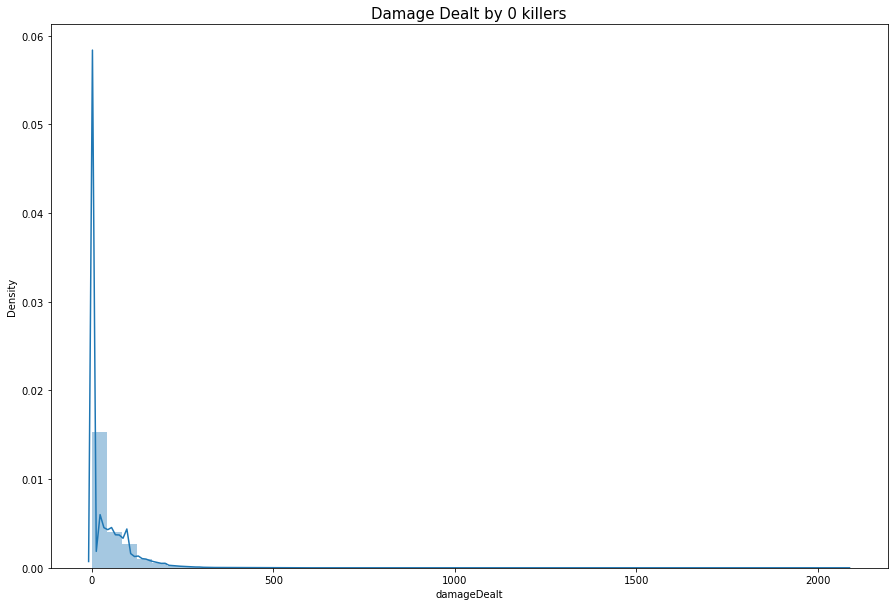

In [5]:
data = train.copy()
data = data[data['kills']==0]
plt.figure(figsize=(15,10))
plt.title("Damage Dealt by 0 killers",fontsize=15)
sns.distplot(data['damageDealt'])
plt.show()

In [6]:
print("{} players ({:.4f}%) have won without a single kill!".format(len(data[data['winPlacePerc']==1]), 100*len(data[data['winPlacePerc']==1])/len(train)))

data1 = train[train['damageDealt'] == 0].copy()
print("{} players ({:.4f}%) have won without dealing damage!".format(len(data1[data1['winPlacePerc']==1]), 100*len(data1[data1['winPlacePerc']==1])/len(train)))

16666 players (0.3748%) have won without a single kill!
4770 players (0.1073%) have won without dealing damage!


Apparentrly killing has a correlation with winning. Finally let's group players based on kills (0 kills, 1-2 kills, 3-5 kills, 6-10 kills and 10+ kills).

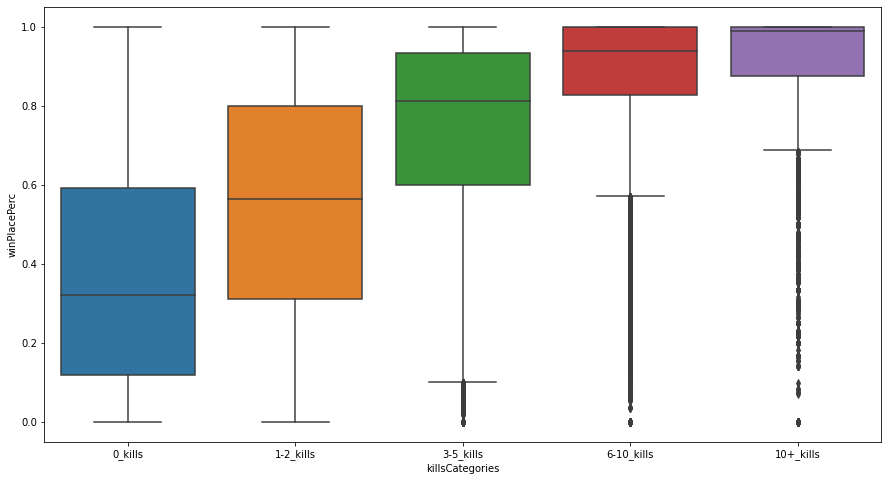

In [7]:
kills = train.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 60], labels=['0_kills','1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(15,8))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)
plt.show()

**The Runners**

In [8]:
print("The average person walks for {:.1f}m, 99% of people have walked {}m or less, while the marathoner champion walked for {}m.".format(train['walkDistance'].mean(), train['walkDistance'].quantile(0.99), train['walkDistance'].max()))

The average person walks for 1154.2m, 99% of people have walked 4396.0m or less, while the marathoner champion walked for 25780.0m.


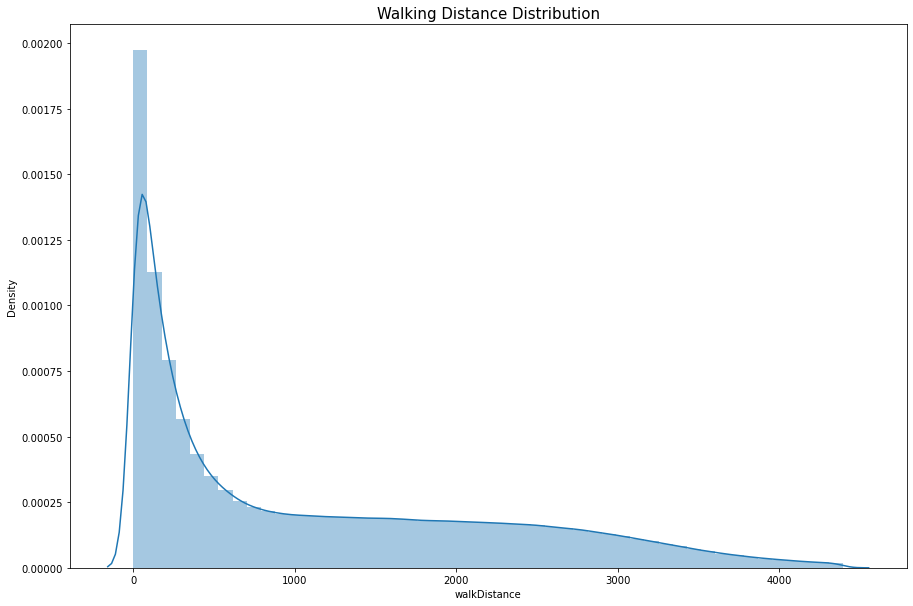

In [9]:
data = train.copy()
data = data[data['walkDistance'] < train['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title("Walking Distance Distribution",fontsize=15)
sns.distplot(data['walkDistance'])
plt.show()

In [10]:
print("{} players ({:.4f}%) walked 0 meters. This means that they die before even taking a step or they are afk (more possible).".format(len(data[data['walkDistance'] == 0]), 100*len(data1[data1['walkDistance']==0])/len(train)))

99603 players (2.0329%) walked 0 meters. This means that they die before even taking a step or they are afk (more possible).


**The Drivers**

In [11]:
print("The average person drives for {:.1f}m, 99% of people have drived {}m or less, while the formula 1 champion drived for {}m.".format(train['rideDistance'].mean(), train['rideDistance'].quantile(0.99), train['rideDistance'].max()))

The average person drives for 606.1m, 99% of people have drived 6966.0m or less, while the formula 1 champion drived for 40710.0m.


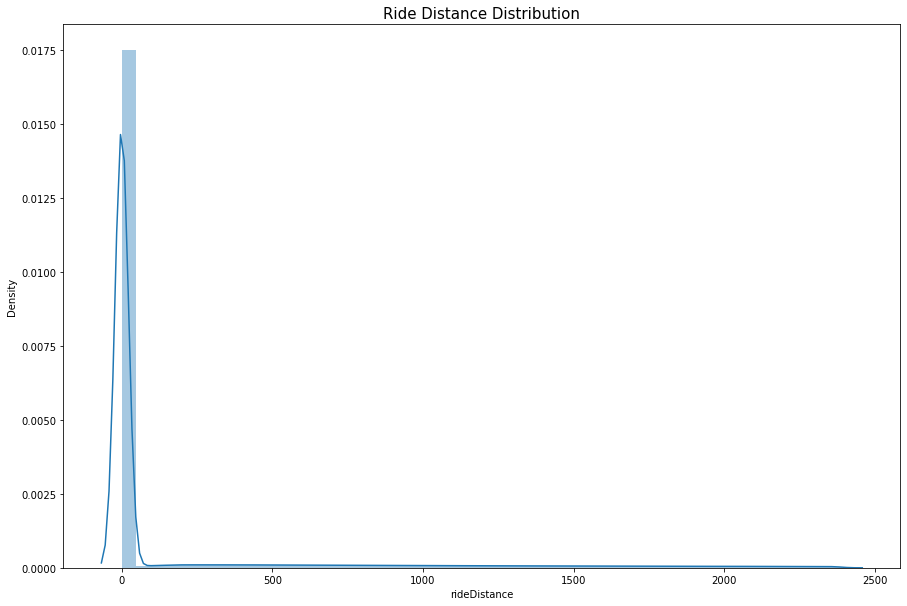

In [12]:
data = train.copy()
data = data[data['rideDistance'] < train['rideDistance'].quantile(0.9)]
plt.figure(figsize=(15,10))
plt.title("Ride Distance Distribution",fontsize=15)
sns.distplot(data['rideDistance'])
plt.show()

In [13]:
print("{} players ({:.4f}%) drived for 0 meters. This means that they don't have a driving licence yet.".format(len(data[data['rideDistance'] == 0]), 100*len(data1[data1['rideDistance']==0])/len(train)))

3309429 players (23.1022%) drived for 0 meters. This means that they don't have a driving licence yet.


Destroying a vehicle in my experience shows that a player has skills. Let's check it.

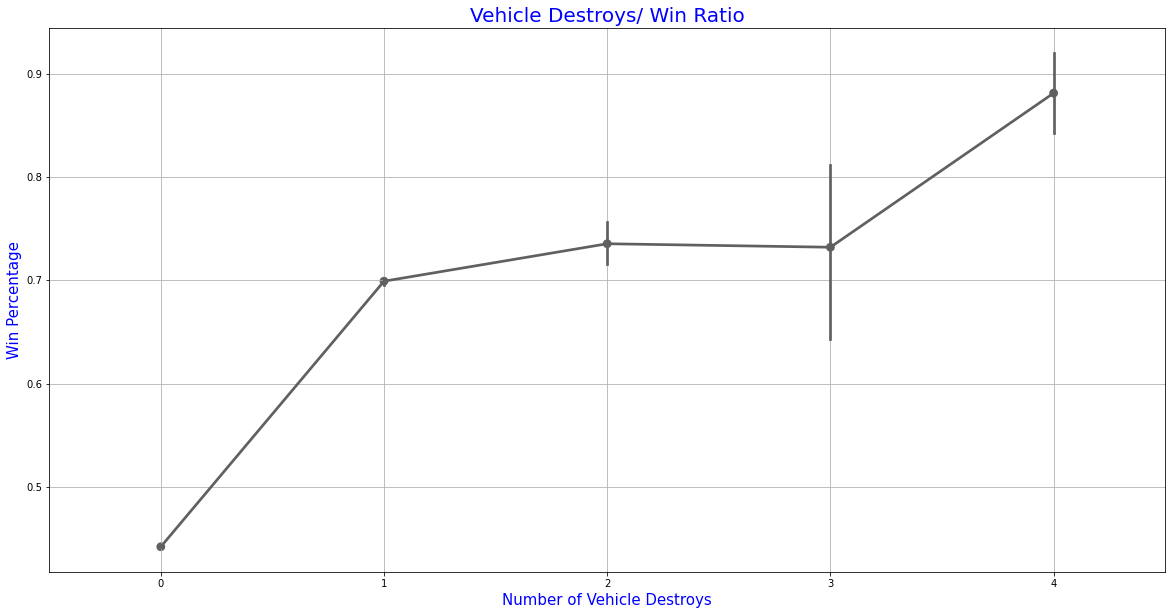

In [14]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='vehicleDestroys',y='winPlacePerc',data=data,color='#606060',alpha=0.8)
plt.xlabel('Number of Vehicle Destroys',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Vehicle Destroys/ Win Ratio',fontsize = 20,color='blue')
plt.grid()
plt.show()

**The Swimmers**

In [15]:
print("The average person swims for {:.1f}m, 99% of people have swimemd {}m or less, while the olympic champion swimmed for {}m.".format(train['swimDistance'].mean(), train['swimDistance'].quantile(0.99), train['swimDistance'].max()))

The average person swims for 4.5m, 99% of people have swimemd 123.0m or less, while the olympic champion swimmed for 3823.0m.


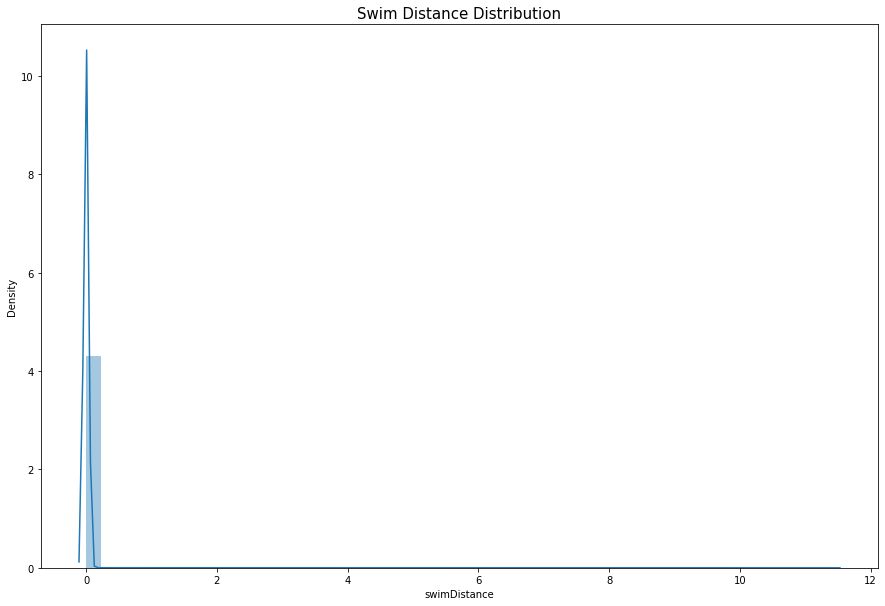

In [16]:
data = train.copy()
data = data[data['swimDistance'] < train['swimDistance'].quantile(0.95)]
plt.figure(figsize=(15,10))
plt.title("Swim Distance Distribution",fontsize=15)
sns.distplot(data['swimDistance'])
plt.show()

Almost no one swims. Let's group the swimming distances in 4 categories and plot vs winPlacePerc.

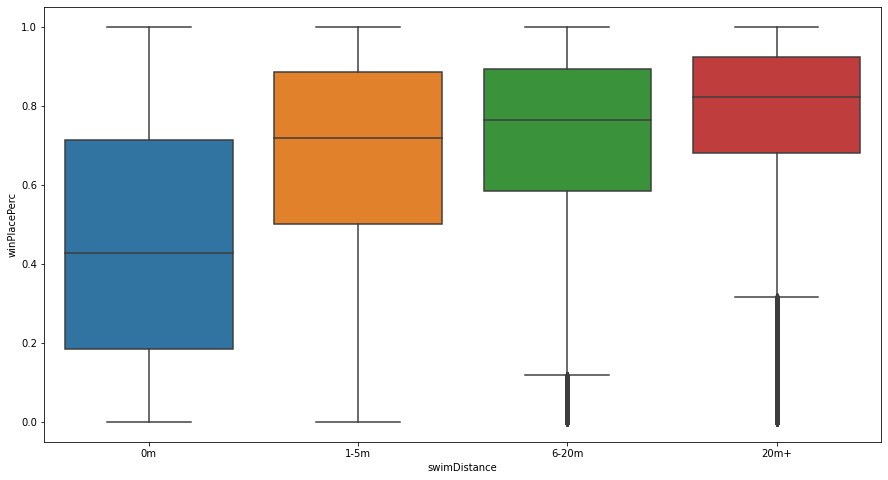

In [17]:
swim = train.copy()

swim['swimDistance'] = pd.cut(swim['swimDistance'], [-1, 0, 5, 20, 5286], labels=['0m','1-5m', '6-20m', '20m+'])

plt.figure(figsize=(15,8))
sns.boxplot(x="swimDistance", y="winPlacePerc", data=swim)
plt.show()

It seems that if you swim, you rise to the top. In PUBG there are currently 3 maps. One of them has almost no water. Keep that in mind. I might plan on doing analysis to find out in which map a match is played.

**The Healers**

In [18]:
print("The average person uses {:.1f} heal items, 99% of people use {} or less, while the doctor used {}.".format(train['heals'].mean(), train['heals'].quantile(0.99), train['heals'].max()))
print("The average person uses {:.1f} boost items, 99% of people use {} or less, while the doctor used {}.".format(train['boosts'].mean(), train['boosts'].quantile(0.99), train['boosts'].max()))

The average person uses 1.4 heal items, 99% of people use 12.0 or less, while the doctor used 80.
The average person uses 1.1 boost items, 99% of people use 7.0 or less, while the doctor used 33.


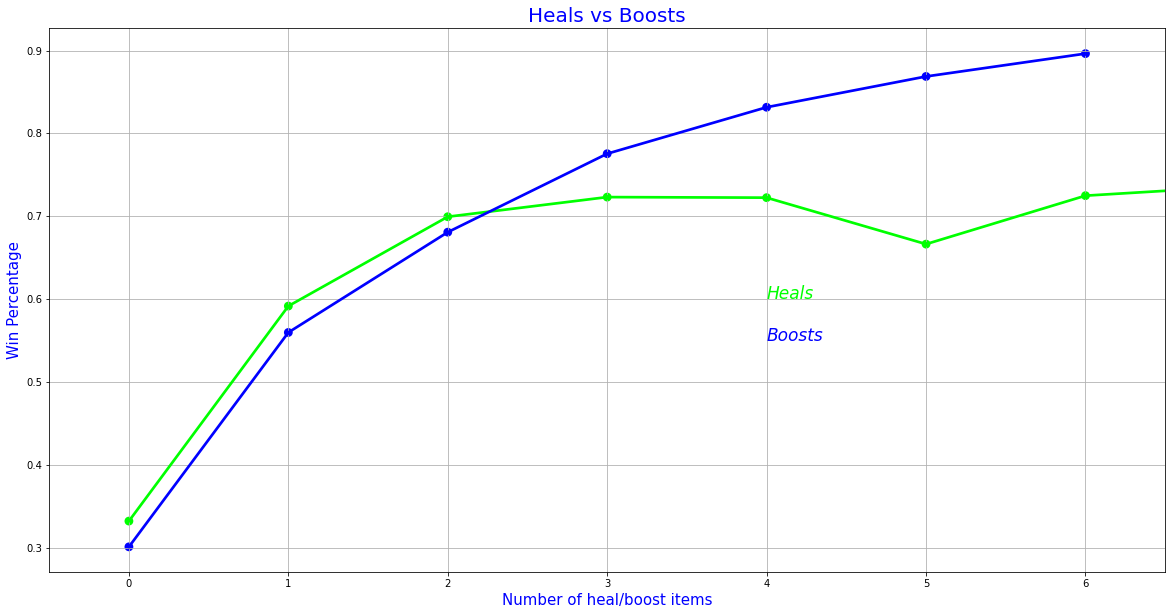

In [19]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='lime',alpha=0.8)
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='blue',alpha=0.8)
plt.text(4,0.6,'Heals',color='lime',fontsize = 17,style = 'italic')
plt.text(4,0.55,'Boosts',color='blue',fontsize = 17,style = 'italic')
plt.xlabel('Number of heal/boost items',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Heals vs Boosts',fontsize = 20,color='blue')
plt.grid()
plt.show()

**Correlation between variables**

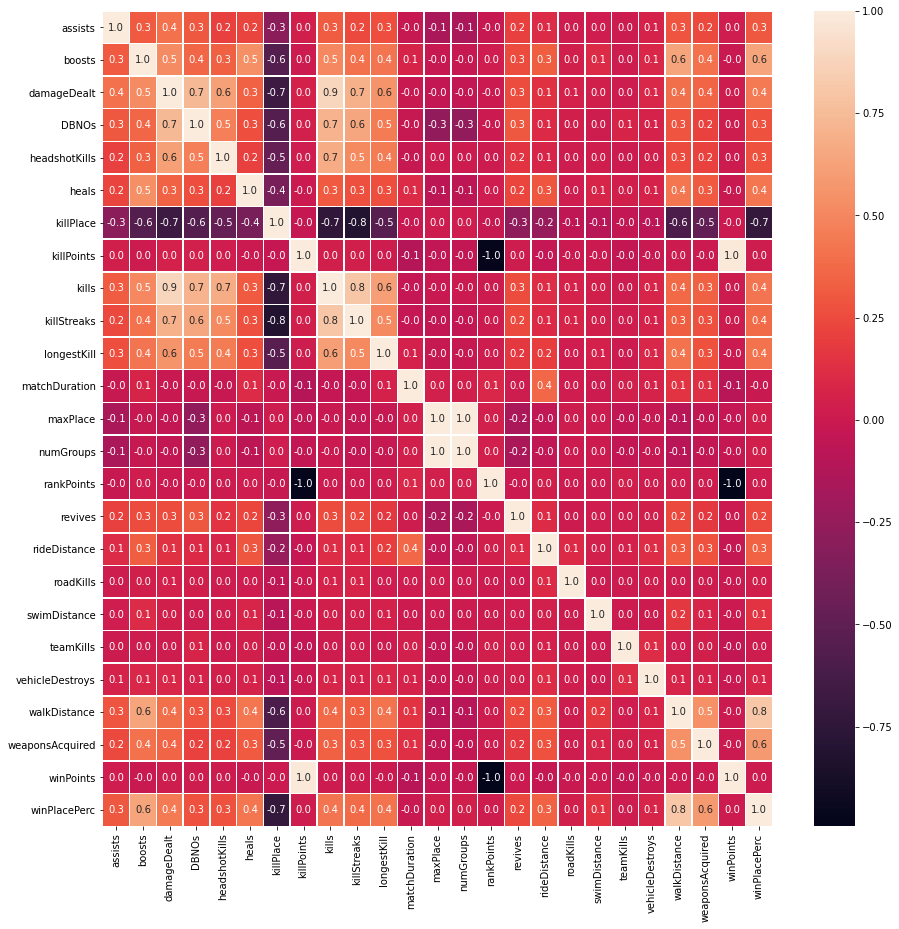

In [20]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

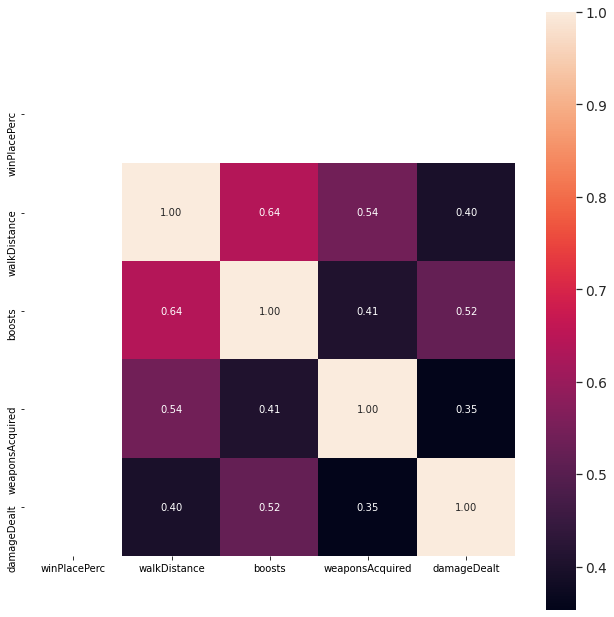

In [21]:
k = 5
f,ax = plt.subplots(figsize=(11, 11))
cols = train.corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()